# Preamble

In [1]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.sparse as ss

In [3]:
import itertools
import os
import pandas as pd

In [4]:
import sklearn.metrics as skm

from sklearn.model_selection import train_test_split

In [5]:
from code.constants import PROJECT_ROOT
from code.helpers import _FILES

In [6]:
from tqdm import tqdm as tqdm

# Load data

In [7]:
orders_prior = pd.read_hdf('../data/data.hd5', 'orders_prior')
orders_train = pd.read_hdf('../data/data.hd5', 'orders_train')

In [8]:
orders_meta = pd.read_csv(_FILES['orders_meta'])

In [9]:
sample_submission = pd.read_csv(_FILES['samples_submission'])

In [10]:
products = pd.read_csv(_FILES['products'])

# Experimentation

## Compute as if just guess sample submission products

#### What does the target even look like?

In [11]:
products.shape

(49688, 4)

#### So...it's a 49,688 dimensional vector? Nicely the ids are contiguous

In [12]:
target_train = orders_train[lambda _df: _df['reordered'] == 1]

In [13]:
renumber_orders = {order_id: ix for ix, order_id in enumerate(target_train['order_id'].unique())}

In [14]:
target_train_renumbered = target_train.assign(order_id=lambda _df: _df['order_id'].map(renumber_orders))

In [15]:
sparse_rows, sparse_cols = zip(*target_train_renumbered[['order_id', 'product_id']].values.tolist())
sparse_cols = [i-1 for i in sparse_cols]

In [16]:
N_train = target_train['order_id'].nunique()
N_products = products.shape[0]

In [17]:
target_train_as_csc = ss.csc_matrix((np.ones(len(sparse_rows)), (sparse_rows, sparse_cols)), 
                                    shape=(N_train, N_products))

#### Create the sample submission target

In [18]:
sample_submission.head()

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259


In [19]:
simple_train_submission_rows = [i for i in xrange(N_train) for _ in xrange(2)]

In [20]:
simple_train_submission_cols = [i for _ in xrange(N_train) for i in [39276, 29259]]

In [21]:
simple_train_submission_vals = [1 for _ in xrange(N_train) for _ in xrange(2)]

In [22]:
simple_guess = ss.csc_matrix((simple_train_submission_vals, 
                              (simple_train_submission_rows, simple_train_submission_cols)),
                             shape=(N_train, N_products))

In [23]:
#### I think this is what I want (global true / false positives)
skm.f1_score(target_train_as_csc, simple_guess, labels=range(N_products), average='micro')

2.6069841104318475e-05

Is there an alternative way to compute this that's easier? unconvinced

## Compute by guessing all their prior purchased items

#### Count prior orders by user

In [24]:
orders_by_user = (orders_meta[['order_id', 'user_id']]
                  .merge(orders_meta
                         [lambda _df: _df['eval_set'] != 'prior']
                         [['user_id', 'eval_set']].drop_duplicates()))

In [25]:
orders_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [26]:
num_orders_by_user = (orders_prior[['order_id', 'product_id']]
                      .merge(orders_by_user, how='left')
                      [['order_id', 'user_id']]
                      .drop_duplicates()
                      .groupby(['user_id']).size()
                      .to_frame('num_orders'))

In [27]:
prior_orders_by_user = (orders_prior[['order_id', 'product_id']]
                        .merge(orders_by_user, how='left')
                        [['user_id', 'eval_set', 'product_id', 'order_id']]
                        .drop_duplicates()
                        .groupby(['user_id', 'eval_set', 'product_id'])
                        .size()
                        .to_frame('num_times_ordered'))

In [28]:
prior_order_counts = (prior_orders_by_user.reset_index().merge(num_orders_by_user.reset_index())
                      .assign(frac_times_ordered=lambda _df: _df['num_times_ordered'] / _df['num_orders']))

#### Create the test matrix

In [29]:
def create_sparse(orders, products, values, shape, order_ix_map=None):
    if isinstance(values, int):
        values = np.ones(orders.shape) * values
        
    if not order_ix_map:
        order_ix_map = {order: ix for ix, order in enumerate(set(orders))}
        
    sparse_vals = values
    sparse_rows = [order_ix_map[x] for x in orders]
    sparse_cols = [x - 1 for x in products]  # product ids are rep'd as contiguous counts starting at 1
    
    return ss.csc_matrix((sparse_vals, (sparse_rows, sparse_cols)), shape=shape), order_ix_map

In [30]:
target_train = orders_train[lambda _df: _df['reordered'] == 1]

In [31]:
order_ix_map = {order: ix for ix, order in 
                enumerate(set(orders_meta[lambda _df: _df['eval_set'] == 'train']['order_id']))}

In [32]:
sparse_target_train, _ = create_sparse(target_train['order_id'], target_train['product_id'], 1,
                                                  (len(order_ix_map), products.shape[0]),
                                                  order_ix_map)

#### Construct predictions

In [33]:
train_order_ids = orders_meta[lambda _df: _df['eval_set'] == 'train'][['order_id', 'user_id']]

In [34]:
train_order_preds = (prior_order_counts[lambda _df: _df['eval_set'] == 'train'][['user_id', 'product_id', 'frac_times_ordered']]
                     .merge(train_order_ids))

In [35]:
sparse_train_order_preds, _ = create_sparse(train_order_preds['order_id'], 
                                            train_order_preds['product_id'],
                                            train_order_preds['frac_times_ordered'],
                                            (len(order_ix_map), products.shape[0]),
                                            order_ix_map)

In [36]:
pred_valid_train, pred_valid_test, act_valid_train, act_valid_test = train_test_split(
    sparse_train_order_preds, sparse_target_train, train_size=0.8, random_state=1
)

In [43]:
scores_across_thresh = pd.Series({
    '{:.02f}'.format(thresh): skm.f1_score(act_valid_train,
                                           (pred_valid_train > thresh),
                                           labels=range(products.shape[0]),
                                           average='micro')
    for thresh in tqdm(np.linspace(0, 1, 101)[1:])
})

 99%|█████████▉| 99/100 [00:18<00:00,  6.53it/s]/Users/anthonyliu/Documents/main/instacart/venv/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 100/100 [00:18<00:00,  6.68it/s]


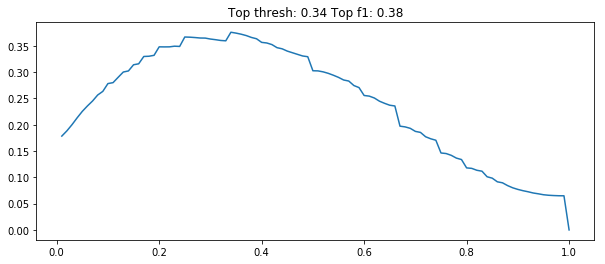

In [44]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(scores_across_thresh)
ax.set_title('Top thresh: {:s} Top f1: {:.2f}'.format(scores_across_thresh.argmax(), scores_across_thresh.max()))

In [46]:
skm.f1_score(act_valid_test, (pred_valid_test > 0.34), labels=range(products.shape[0]), average='micro')

0.37378731343283583

#### Make submission

In [47]:
test_order_ix_map = {order: ix for ix, order in 
                     enumerate(set(orders_meta[lambda _df: _df['eval_set'] == 'test']['order_id']))}

In [48]:
test_order_ids = orders_meta[lambda _df: _df['eval_set'] == 'test'][['order_id', 'user_id']]

In [49]:
test_order_preds = (prior_order_counts[lambda _df: _df['eval_set'] == 'test']
                    [['user_id', 'product_id', 'frac_times_ordered']]
                    .merge(test_order_ids))

In [86]:
def join_as_str(x, sep=' '):
    return sep.join(str(_x) for _x in x)

In [91]:
over_thresh = (test_order_preds[lambda _df: _df['frac_times_ordered'] > 0.34]
               .groupby('order_id')['product_id'].apply(join_as_str)
               .reset_index())

In [94]:
full_solution_set = (test_order_ids.merge(over_thresh)
                     .drop('user_id', axis=1)
                     .fillna({'product_id': 'None'})
                     .sort_values('order_id'))

In [98]:
as_string = '\n'.join(join_as_str(row, ',') for _, row in full_solution_set.iterrows())